In [23]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy import stats

In [24]:
normal_vag_subjects = [] # 51
pathology_vag_subjects = [] # 38

healthy_dir = "../data/open_vag/normal/"
pathology_dir = "../data/open_vag/pathology/"
#healthy_base = "novag"
#pathology_base  = "abvag"


exclude = {".ipynb_checkpoints"}

healthy_files = [f for f in os.listdir(healthy_dir) if '.ipynb_checkpoints' not in f]
print(f" healthy vag signals {len(healthy_files)}")
pathology_files = [f for f in os.listdir(pathology_dir) if '.ipynb_checkpoints' not in f]
print(f" pathology vag signals {len(pathology_files)}")

max_size_files = max(len(healthy_files), len(pathology_files))

for i in range(0, max_size_files):
    if(i < len(healthy_files)):
        # read in a healthy_file
        file_path = os.path.join(healthy_dir, healthy_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            normal_vag_subjects.append(vags)
    if(i < len(pathology_files)):
        file_path = os.path.join(pathology_dir, pathology_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            pathology_vag_subjects.append(vags)  

print(len(normal_vag_subjects), len(pathology_vag_subjects))


 healthy vag signals 51
 pathology vag signals 38
51 38


In [25]:
# amplitude normalisation
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def resample_signal(signal, points):
    s_res = resample(signal, points)
    return s_res

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

# variables
n_l = 8192
fs = 2000 # 2khz sampling rate
low_cut_off = 10 # removes muscle artifacts and baseline wander
high_cut_off = 950
filter_order = 5   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass", high, low
b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)


In [26]:
n_norm_res = []
p_norm_res = []

for d_set in normal_vag_subjects:
    n = amplitude_normal(d_set)
    y_new = resample(n, n_l)
    y_new_f = filter_signal(b,a,y_new,"filtfilt")
    n_norm_res.append(y_new_f)

for d_set in pathology_vag_subjects:
    p = amplitude_normal(d_set)
    y_new = resample(p, n_l)
    y_new_f = filter_signal(b,a,y_new,"filtfilt")
    p_norm_res.append(y_new_f)

print(len(n_norm_res), len(p_norm_res))

51 38


In [27]:
#fig, ax = plt.subplots(len(normal_vag_subjects),2, figsize=(20, 100))
#for i, n in enumerate(n_norm_res):
#    ax[i][0].plot(n)
#for i, p in enumerate(p_norm_res):
#ax[i][1].plot(p)

In [28]:
#fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

#for i, d in enumerate(n_norm_res):
#    t_n = np.arange(1, len(d) + 1) / fs

#    t_n_2 = np.arange(1, len(n_norm[i])+1) / fs
#    ax[i][0].plot(t_n, d, color="m")
#    ax[i][1].plot(t_n_2, n_norm[i], color="c")
#    #ax[i][1].plot(t_n, n_hanning[i], color="black")

In [86]:
# functions

def split_signal(signal):
    middle = len(signal) // 2
    # Split the array into two halves
    first_half = signal[:middle]
    second_half = signal[middle:]
    
    return [first_half, second_half]

def apply_hanning(d):
    hanning_window = np.hanning(len(d))
    windowed_signal = d * hanning_window
    return windowed_signal

# assumes len(data) is a fft multiple i.e 4096 or 8192
def compute_fft_mag(data):
    fftpoints = len(data) #int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) #/ (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

# the only way this comes out is if the slope is made a positive value if negative
def compute_fd(slope):
    fd = (5 - abs(slope)) / 2
    return fd

# FD function
def compute_fd_from_signal(s, fs):
    # apply hanning window
    hann = apply_hanning(s)
    dft_result = np.fft.fft(hann)

    # psd
    x_f = np.fft.fftfreq(len(hann), d=1/fs)
    psd = np.abs(dft_result) ** 2
    mask = x_f > 0
    #postive side of FFT / PSD
    pos_f = x_f[mask]
    pos_psd = psd[mask]  # Filter PSD using the same mask

    # log log
    log_f = np.log(pos_f)
    log_psd = np.log(pos_psd)

    # slope and best fit
    indices = np.where((pos_f >= 10) & (pos_f <= 300))[0]

    x = log_f[indices]
    y = log_psd[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)

    #fractal dimension
    fd_n = compute_fd(m)
    return fd_n

In [87]:

# store a bunch of stuff
n_pwr = []
n_pwr_freqs = []
p_pwr = []
p_pwr_freqs = []
n_log = []
p_log = []
n_best_fit = []
p_best_fit = []
n_slope = []
p_slope = []

n_norm_fd = []
p_norm_fd = []

# all FD features
n_fd_features = []
p_fd_features = []

# normal resampled, filtered data - healthy
for i, d_set in enumerate(n_norm_res):

    if(i==0):
        fd_test = compute_fd_from_signal(d_set, fs) # extension
        print(fd_test)

    # compute main FD feature here so that we can store all the parts of it
    # apply hanning window
    n_hann = apply_hanning(d_set)
    dft_result = np.fft.fft(n_hann)

    # psd
    x_f = np.fft.fftfreq(len(n_hann), d=1/fs)
    psd = np.abs(dft_result) ** 2
    mask = x_f > 0
    #postive side of FFT / PSD
    pos_f_n = x_f[mask]

    pos_psd_n = psd[mask]  # Filter PSD using the same mask

    # log log
    log_f_n = np.log(pos_f_n)
    log_psd_n = np.log(pos_psd_n)

    # slope and best fit
    indices = np.where((pos_f_n >= 10) & (pos_f_n <= 300))[0]

    x = log_f_n[indices]
    y = log_psd_n[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)
    fit = m*x+b

    #fractal dimension
    fd_n = compute_fd(m)
    if(i==0):
        print(fd_n)

    # fd1, fd2 - EXT / FLEX
    ext_flex = split_signal(d_set)  # ext is 0 and flex is 1
    FD1_ext = compute_fd_from_signal(ext_flex[0], fs) # extension
    FD2_flex = compute_fd_from_signal(ext_flex[1], fs) # flexion

    ext_quarters = split_signal(ext_flex[0])
    FD1_ext_q1 = compute_fd_from_signal(ext_quarters[0],fs)
    FD1_ext_q2 = compute_fd_from_signal(ext_quarters[1],fs)

    flex_quarters = split_signal(ext_flex[1])
    FD2_flex_q1 = compute_fd_from_signal(flex_quarters[0],fs)
    FD2_flex_q2 = compute_fd_from_signal(flex_quarters[1], fs)

    n_fd_features.append([fd_n, FD1_ext, FD1_ext_q1, FD1_ext_q2, FD2_flex, FD2_flex_q1, FD2_flex_q2 ])

    # store the computations
    n_pwr_freqs.append(x)
    n_pwr.append(psd)
    n_log.append([log_f_n, log_psd_n])
    n_slope.append(m)
    n_best_fit.append([log_f_n[indices], fit])
    n_norm_fd.append(fd_n)

for d_set in p_norm_res:

    p_hann = apply_hanning(d_set)
    dft_result = np.fft.fft(p_hann)
    x_f = np.fft.fftfreq(len(p_hann), d=1/fs)
    psd = np.abs(dft_result) ** 2
    #postive side of FFT / PSD
    mask = x_f > 0
    # Apply the mask to both frequencies and PSD to ensure they are aligned
    pos_f_p = x_f[mask]
    pos_psd_p = psd[mask]  # Filter PSD using the same mask
    # log - log
    log_f_p = np.log(pos_f_p)
    log_psd_p = np.log(pos_psd_p)

    indices = np.where((pos_f_p >= 10) & (pos_f_p <= 300))[0]
    x = log_f_p[indices]
    y = log_psd_p[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)
    fit = m*x+b

    #fractal dimension
    fd_p = compute_fd(m)

     # fd1, fd2 - EXT / FLEX
    ext_flex = split_signal(d_set)  # ext is 0 and flex is 1
    FD1_ext = compute_fd_from_signal(ext_flex[0], fs) # extension
    FD2_flex = compute_fd_from_signal(ext_flex[1], fs) # flexion

    ext_quarters = split_signal(ext_flex[0])
    FD1_ext_q1 = compute_fd_from_signal(ext_quarters[0],fs)
    FD1_ext_q2 = compute_fd_from_signal(ext_quarters[1],fs)

    flex_quarters = split_signal(ext_flex[1])
    FD2_flex_q1 = compute_fd_from_signal(flex_quarters[0],fs)
    FD2_flex_q2 = compute_fd_from_signal(flex_quarters[1], fs)

    p_fd_features.append([fd_p, FD1_ext, FD1_ext_q1, FD1_ext_q2, FD2_flex, FD2_flex_q1, FD2_flex_q2 ])
    
    p_pwr_freqs.append(x_f)
    p_pwr.append(psd)
    p_log.append([log_f_p, log_psd_p])
    p_slope.append(m)
    p_best_fit.append([log_f_p[indices], fit])
    p_norm_fd.append(fd_p)


1.7302725143270978
1.7302725143270978


In [88]:
# plot the log log and line of best fit for one vag signal
#fig, ax = plt.subplots(1,1, figsize=(20, 5))

#ax.plot(n_log[10][0], n_log[10][1], color="m")
#ax.plot(n_best_fit[10][0], n_best_fit[10][1], color="black")


The best method available to estimate the FD of a self-affine signal is PSA. As explained in Section 1.1, an fBm signal has a PSD that
follows the 1/f model. A high value of ˇ indicates a rapid decrease
in the high-frequency content of the signal. A self-affine fBm function in an E-dimensional Euclidean space has its PSD PV(f) ∝ 1/f
with

FD = E + 1 − H
H = B - 1 /2

FD = E + 1 - ((B-1)/2))

If E = 1

FD = 5-B / 2

the average and standard deviation values of FD for the 51 normal signals were 1.8061 ± 0.2398;
those for the 38 abnormal VAG signals were 1.6695 ± 0.2226 (using the frequency range [10, 300] Hz

In [89]:
#[fd_p, FD1_ext, FD1_ext_q1, FD1_ext_q2, FD2_flex, FD2_flex_q1, FD2_flex_q2 ]

n_fd = np.array([lst[0] for lst in n_fd_features])
p_fd = np.array([lst[0] for lst in p_fd_features])
n_fd1_ext = np.array([lst[1] for lst in n_fd_features])
p_fd1_ext = np.array([lst[1] for lst in p_fd_features])
n_fd2_flex = np.array([lst[4] for lst in p_fd_features])
p_fd2_flex = np.array([lst[4] for lst in p_fd_features])

print(f"avg fd normal: {float(np.mean(n_norm_fd))} +/- {round(np.std(n_norm_fd),4)}")
print(f"avg fd pathol: {np.mean(p_norm_fd)} +/- {round(np.std(p_norm_fd),4)}")
print()
print(f"avg fd ext nomral: {np.mean(n_fd1_ext)} +/- {round(np.std(n_fd1_ext),4)}")
print(f"avg fd ext pathol: {np.mean(p_fd1_ext)} +/- {round(np.std(p_fd1_ext),4)}")
print()
fd_t, fd_p_value = stats.ttest_ind(n_fd, p_fd)
fd_ext, fd_ext_p_value = stats.ttest_ind(n_fd1_ext, p_fd1_ext)
fd_flex, fd_flex_p_value = stats.ttest_ind(n_fd2_flex, p_fd2_flex)

print("FD P-value:", fd_p_value, "paper p value", 0.0075)
print("FD ext P-value:", fd_ext_p_value, "paper p value", 0.0850)
print("FD flex P-value:", fd_flex_p_value, "paper p value", 0.0573)

avg fd normal: 1.8596619687029254 +/- 0.2264
avg fd pathol: 1.726514685372402 +/- 0.2189

avg fd ext nomral: 1.9350743358045597 +/- 0.2879
avg fd ext pathol: 1.8508123369501785 +/- 0.2526

FD P-value: 0.0072071694741472694 paper p value 0.0075
FD ext P-value: 0.15859960527297162 paper p value 0.085
FD flex P-value: 1.0 paper p value 0.0573


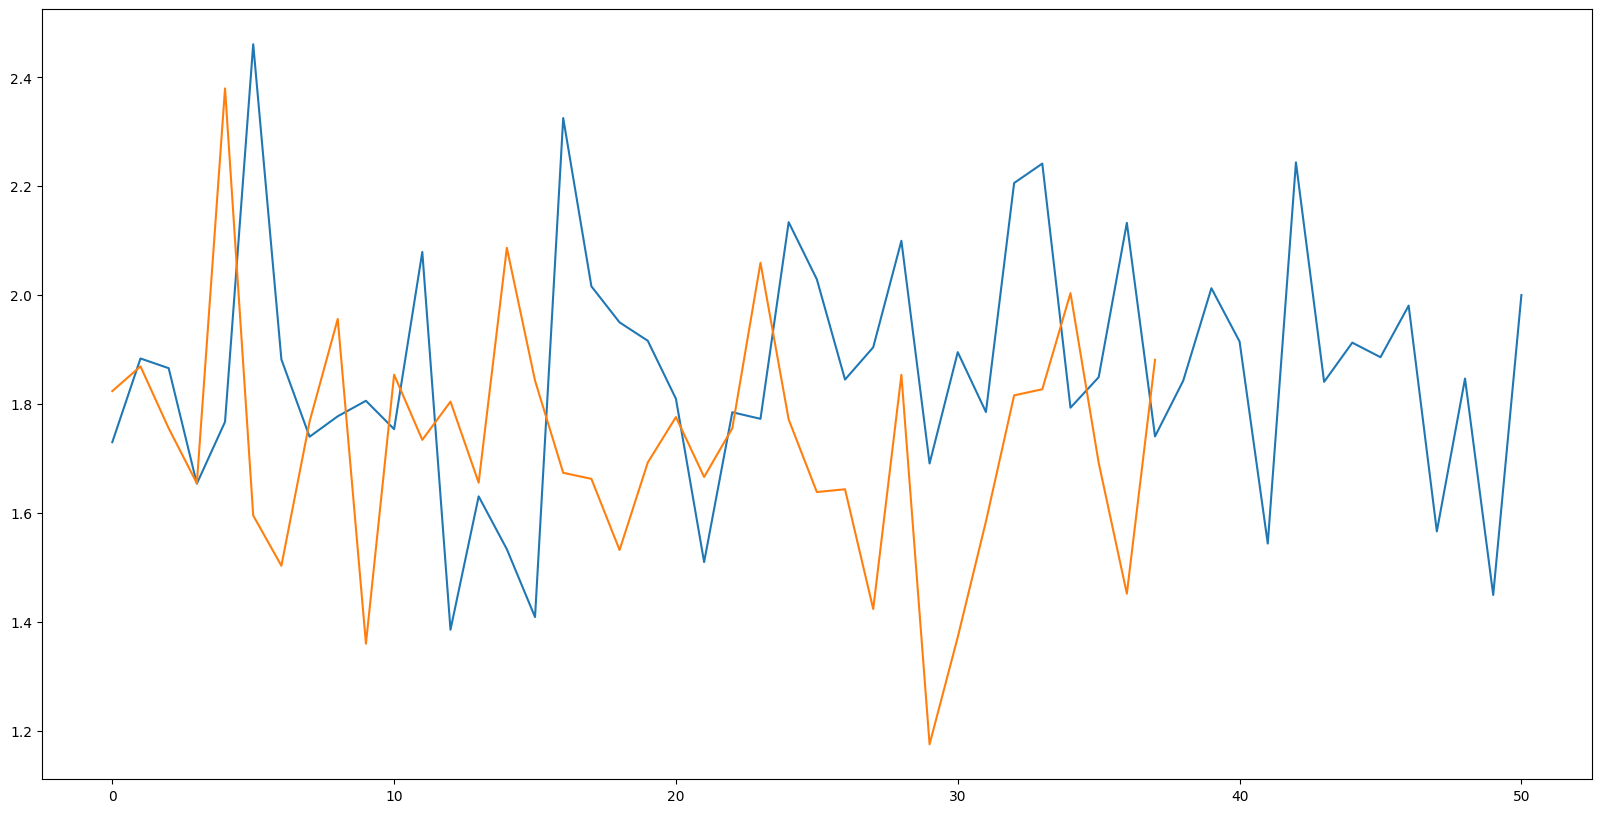

In [90]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(n_norm_fd)
ax.plot(p_norm_fd)